# Hackathon 7

Written by Eleanor Quint
Modified by Mrinal Rawool

Topics:
- Techniques for dimension expansion
    - Transpose convolutions
    - Sub-pixel convolutions
    - ProgressiveGAN upscaling
- Autoencoding
    - Sparse autoencoders
    - De-noising autoencoders

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

Why Autoencoders?

- We want to learn latent(hidden) representation of input data without any supervision.

An autoencoder uses the encoder-decoder architecture. Encoder takes in the input and creates its latent representation. Decoder takes the latent representation and (ideally, once it undergoes training) reproduces the input data at its output.

Autoencoders are catgorized based on how constraints applied to facilitate learning.
Category: Implementation | Architectures
- Stacked: # layers in E and D are same (symmetrical architecture). Optionally, weight tying is also used to reduce # parameters.
- Convolutional: Uses convolutional and pooling layer to reduce the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps)
Category: Input processing
- Denoising: Model input is noisy data. Model output is supposed to be the original uncorrupted data.
Category: # neurons available for Latent representation
- Sparse: Uses sparsity as a constraint to enable good feature extraction. This forces the autoencoder to represent each input as a combination of a small number of activations.
Category:
- Variational: Two special properties. They are probabilistic and generative. The encoder produces a mean coding and a standard devisation for every input. A Gaussian distribution is generated using these values and the actual coding of the input is then sampled from this Gaussian distribution. To generate new inputs, simply sample a random coding from the distribution created for the input.

This notebook takes you through two types of auto-encoders:

- Sparse
- Denoising

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

In [36]:
# Let's use the code from Hack2 to load MNIST
ds = tfds.load('mnist', shuffle_files=True, data_dir = DATA_DIR) # this loads a dict with the datasets

# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32)

Part 1 deals with techniques to "rearrange" feature maps in a meaningful way such that the model is able to recover the original input from its latent representation.

### Techniques for dimension expansion

Generally, in the classifiers we've used so far, we compress high dimensional representations into lower dimensional ones. Now, we're going to study ways of going from lower dimensional to higher. For this, we're going to define a function `upscale_block` which makes the representation larger, in three different ways.



#### Upscaling blocks:

1. Transpose convolutions
2. Sub pixel convolutions
3. GAN

In [3]:
def conv2d_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """conv2d_transpose"""
    return tf.keras.layers.Conv2D(filters, kernel_size, strides=(scale, scale), padding='same', activation=activation)

conv2d_opb = conv2d_block(64)

#### Transpose convolutions



Although we can upscale unstructured data very easily with a larger dense layer, images are less straightforward to upscale. As the upscaling companion to downscaling convolutions, we can learn to increase the size of images with transpose convolutions. They are sometimes called "deconvolutions" because they're the inverse operation of the convolution, but it is actually the transpose (gradient) of a convolution rather than an actual deconvolution. Transpose convolutions are implemented by [tf.keras.layers.Conv2DTranspose
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).

Why Conv2DTranspose?
- The need for transposed convolutions generally arise from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.

In [4]:
def transpose_conv_upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """conv2d_transpose"""
    return tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=(scale, scale), padding='same', activation=activation)

transpose_conv_upsb = transpose_conv_upscale_block(64)


#### Sub-pixel convolutions



Another approach is called the sub-pixel convolution, which does a regular convolution with many channels, and then re-orders the data into the height and width dimensions from the channels dimension. For some intuition, a graphic:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/03a5b2aac53443e6078f0f63b35d4f95d6d54c5d/2-Figure1-1.png">

(Image sourced from [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158))

In [5]:
def subpixel_upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """[Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158)"""
    # Increase the number of channels to the number of channels times the scale squared
    conv = tf.keras.layers.Conv2D(filters * (scale ** 2), (kernel_size, kernel_size), activation=activation, padding='same')
    # Rearrange blocks of (1,1,scale**2) pixels into (scale,scale,1) pixels
    rearrange = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))
    # Chunks of data of size block_size * block_size from depth are rearranged into non-overlapping blocks of size block_size x block_size
    # The width of the output tensor is input_depth * block_size, whereas the
    # height is input_height * block_size.
    return tf.keras.Sequential([conv, rearrange])

subpixel_upsb = subpixel_upscale_block(64)


You can see that this upscale method uses more parameters than the transpose convolution. This makes it more powerful and flexible (though this isn't always desirable, e.g., if your model is overfitting).

#### ProgressiveGAN upscaling



Finally, one technique that's recently found massive success in Nvidia's ProgressiveGAN used to generate high-resolution fake celebrity faces:

<img src="https://i2.wp.com/robotnyheter.se/wp-content/uploads/2018/01/Nvidia_GAN_ansikten.jpg?w=1561" width="70%">

None of these are real photos, they've all been upsampled in the GAN framework from Gaussian noise with an architecture that uses this technique. It upscales using a classical algorithm like bilinear upscaling and then transforms the output with convolutional layers.

In [6]:
def prog_gan_upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """ similar to the upsampling used in [ProgressiveGAN](https://arxiv.org/pdf/1710.10196.pdf) """
    def upscale(x):
        n, w, h, c = x.get_shape().as_list()
        return tf.image.resize(x, [scale*h, scale*w])

    upscale_layer = tf.keras.layers.Lambda(upscale)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation=activation)
    return tf.keras.Sequential([upscale_layer, conv])

prog_gan_upsb = prog_gan_upscale_block(64)


#### Everything in action for a batch of mnist

In [7]:
for batch in train_ds:
    img = tf.cast(batch['image'], tf.float32)

    # simple conv
    conv2d_maps = conv2d_opb(img)
    print("Original shape:", img.shape, "After Conv2D:", conv2d_maps.shape)
    print('Parameters: ' + str(conv2d_opb.count_params()))

    # TC
    transpose_conv_maps = transpose_conv_upsb(img)
    print("Original shape:", img.shape, "After Transpose Conv:", transpose_conv_maps.shape)
    print('Parameters: ' + str(transpose_conv_upsb.count_params()))

    # SP
    subpixel_maps = subpixel_upsb(img)
    print("Original shape:", img.shape, "After subpixel Conv:", subpixel_maps.shape)
    print('Parameters: ' + str(subpixel_upsb.count_params()))

    #PGAN
    prog_gan_maps = prog_gan_upsb(img)
    print("Original shape:", img.shape, "After PGAN:", prog_gan_maps.shape)
    print('Parameters: ' + str(prog_gan_upsb.count_params()))

    break

Original shape: (32, 28, 28, 1) After Conv2D: (32, 14, 14, 64)
Parameters: 640
Original shape: (32, 28, 28, 1) After Transpose Conv: (32, 56, 56, 64)
Parameters: 640
Original shape: (32, 28, 28, 1) After subpixel Conv: (32, 56, 56, 64)
Parameters: 2560
Original shape: (32, 28, 28, 1) After PGAN: (32, 56, 56, 64)
Parameters: 640


Examine results for one image

(14, 14, 64)
(56, 56, 64)
(56, 56, 64)
(56, 56, 64)


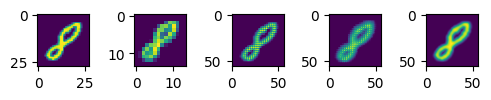

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(5, 3))

img0 = img[0]
axes[0].imshow(img0)

conv2d_maps0 = conv2d_maps[0]
print(conv2d_maps0.shape)
axes[1].imshow(np.expand_dims(tf.math.reduce_mean(conv2d_maps0, axis=2), axis=2))

transpose_conv_maps0 = transpose_conv_maps[0]
print(transpose_conv_maps0.shape)
axes[2].imshow(np.expand_dims(tf.math.reduce_mean(transpose_conv_maps0, axis=2), axis=2))

subpixel_maps0 = subpixel_maps[0]
print(subpixel_maps0.shape)
axes[3].imshow(np.expand_dims(tf.math.reduce_mean(subpixel_maps0, axis=2), axis=2))

prog_gan_img0 = prog_gan_maps[0]
print(prog_gan_img0.shape)
axes[4].imshow(np.expand_dims(tf.math.reduce_mean(prog_gan_img0, axis=2), axis=2))
fig.tight_layout()

Note for M: Create a dummy image 32x32 full white or full black and run through these networks for viz/ understanding

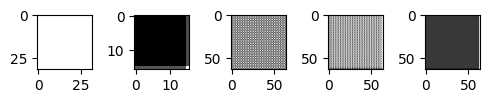

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(5, 3))
demo_img = np.ones((1, 32, 32, 1))
axes[0].imshow(demo_img[0], cmap="Greys")

conv2d_demo = conv2d_opb(demo_img)
axes[1].imshow(np.expand_dims(tf.math.reduce_mean(conv2d_demo[0], axis=2), axis=2), cmap="Greys")

transpose_conv_demo = transpose_conv_upsb(demo_img)
axes[2].imshow(np.expand_dims(tf.math.reduce_mean(transpose_conv_demo[0], axis=2), axis=2), cmap="Greys")

subpixel_demo = subpixel_upsb(demo_img)
axes[3].imshow(np.expand_dims(tf.math.reduce_mean(subpixel_demo[0], axis=2), axis=2), cmap="Greys")

prog_gan_demo = prog_gan_upsb(demo_img)
axes[4].imshow(np.expand_dims(tf.math.reduce_mean(prog_gan_demo[0], axis=2), axis=2), cmap="Greys")

fig.tight_layout()

### Autoencoding

Generally, autoencoding is learning "a complicated identity function". This makes it a form of unsupervised learning, which doesn't require data to be explicitly labeled, but instead looks for patterns and trends in data. Typically the complication is to bottleneck the size of the representation, but can also be more varied. We'll look at code for sparse autoencoders and de-noising autoencoders.

First we'll define some preliminaries that we'll use in both architectures:

In [10]:
def upscale_block(filters, kernel_size=3, scale=2, activation=tf.nn.elu):
    """[Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158)"""
    # Increase the number of channels to the number of channels times the scale squared
    conv = tf.keras.layers.Conv2D(filters * (scale**2),
                                  (kernel_size, kernel_size),
                                  activation=activation,
                                  padding='same')
    # Rearrange blocks of (1,1,scale**2) pixels into (scale,scale,1) pixels
    rearrange = tf.keras.layers.Lambda(
        lambda x: tf.nn.depth_to_space(x, scale))
    return tf.keras.Sequential([conv, rearrange])


class UpscaleBlock(tf.keras.layers.Layer):
    def __init__(self, number, kernel_size=3, activation=tf.nn.swish):
        super().__init__(name="UpscaleBlock" + str(number))
        self.activation = activation
        self.kernel_size = kernel_size
        self.is_built = False

    def build(self, x):
        channels = x.shape.as_list()[-1]
        filters = channels // 2

        bn1 = tf.keras.layers.BatchNormalization()
        conv1 = upscale_block(filters)
        bn2 = tf.keras.layers.BatchNormalization()
        conv2 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       padding='same')
        self.main_network = [self.activation, bn1, conv1, self.activation, bn2, conv2]

        self.skip_connection = upscale_block(filters)
        self.se_activate = SqueezeExcite(filters)
        self.is_built = True

    def __call__(self, input_):
        if not self.is_built:
            self.build(input_)
        x = input_
        for layer in self.main_network:
            x = layer(x)
        output = x
        skip = self.skip_connection(input_)
        return skip + 0.1 * output

In [11]:
class FactorizedReduce(tf.Module):
    """Downscale version of the sub-pixel convolution which re-arranges pixels"""
    def __init__(self, channels):
        super(FactorizedReduce, self).__init__()
        assert channels % 2 == 0
        self.conv_1 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_2 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_3 = tf.keras.layers.Conv2D(channels // 4, 1, strides=2)
        self.conv_4 = tf.keras.layers.Conv2D(channels - 3 * (channels // 4),
                                             1,
                                             strides=2)
        self.convs = [self.conv_1, self.conv_2, self.conv_3, self.conv_4]

    def __call__(self, x):
        """Assumes NHCW data"""
        assert x.shape[2] > 1
        assert x.shape[3] > 1
        out = tf.nn.swish(x)
        conv1 = self.conv_1(out)
        conv2 = self.conv_2(out[:, :, 1:, 1:])
        conv3 = self.conv_3(out[:, :, :, 1:])
        conv4 = self.conv_4(out[:, :, 1:, :])
        out = tf.concat([conv1, conv2, conv3, conv4], -1)
        return out

In [12]:
class SqueezeExcite(tf.Module):
    """Activation function that performs gating"""
    def __init__(self, out_channels):
        super().__init__()
        num_hidden = max(out_channels // 16, 4)
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(num_hidden), tf.keras.layers.Lambda(tf.nn.relu),
            tf.keras.layers.Dense(out_channels), tf.keras.layers.Lambda(tf.nn.sigmoid)
        ])

    def __call__(self, x):
        """The choice of axes assumes we're working with NHWC data"""
        ax = tf.math.reduce_mean(x, axis=[1, 2])
        # data should be flat at this po,int
        bx = self.net(ax)
        cx = tf.expand_dims(tf.expand_dims(bx, 1), 1)
        return cx * x

In [13]:
class DownscaleBlock(tf.keras.layers.Layer):
    def __init__(self, number, kernel_size=3, activation=tf.nn.swish):
        super().__init__(name="DownscaleBlock" + str(number))
        self.activation = activation
        self.kernel_size = kernel_size
        self.is_built = False

    def build(self, x):
        channels = x.shape.as_list()[-1]
        filters = channels * 2

        bn1 = tf.keras.layers.BatchNormalization()
        conv1 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       strides=2,
                                       padding='same')
        bn2 = tf.keras.layers.BatchNormalization()
        conv2 = tf.keras.layers.Conv2D(filters,
                                       self.kernel_size,
                                       padding='same')
        self.main_network = [self.activation, bn1, conv1, self.activation, bn2, conv2]

        self.skip_connection = FactorizedReduce(filters)
        self.se_activate = SqueezeExcite(filters)
        self.is_built = True

    def __call__(self, input_):
        if not self.is_built:
            self.build(input_)
        x = input_
        for layer in self.main_network:
            x = layer(x)
        output = x
        skip = self.skip_connection(input_)
        return skip + 0.1 * output

In [14]:
encoder_network = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same',
                           activation=tf.nn.swish),  #28,28,16
    DownscaleBlock(1),  # 14,14,32
    DownscaleBlock(2),  # 7,7,64
    tf.keras.layers.Conv2D(64, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,64
    tf.keras.layers.Conv2D(16, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,16
    tf.keras.layers.Conv2D(1, 3, padding='same'),  # 7,7,1
])

decoder_network = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,4
    tf.keras.layers.Conv2D(16, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,16
    tf.keras.layers.Conv2D(64, 3, padding='same',
                           activation=tf.nn.swish),  # 7,7,64
    UpscaleBlock(1),  # 14,14,32
    UpscaleBlock(2),  # 28,28,16
    tf.keras.layers.Conv2D(4, 3, padding='same',
                           activation=tf.nn.swish),  #28,28,4
    tf.keras.layers.Conv2D(1, 3, padding='same'),  #28,28,16
])

In [15]:
for batch in train_ds:
    x = tf.cast(batch['image'], tf.float32)
    code = encoder_network(x)
    output = decoder_network(code)
    break
print(x.shape, code.shape, output.shape)

(32, 28, 28, 1) (32, 7, 7, 1) (32, 28, 28, 1)


In the below code, we will be implmenting a sparsity AE and a denoising AE using the same encoder-decoder network that we just created.

Below is the diagrammatic representation of what we are trying to do.

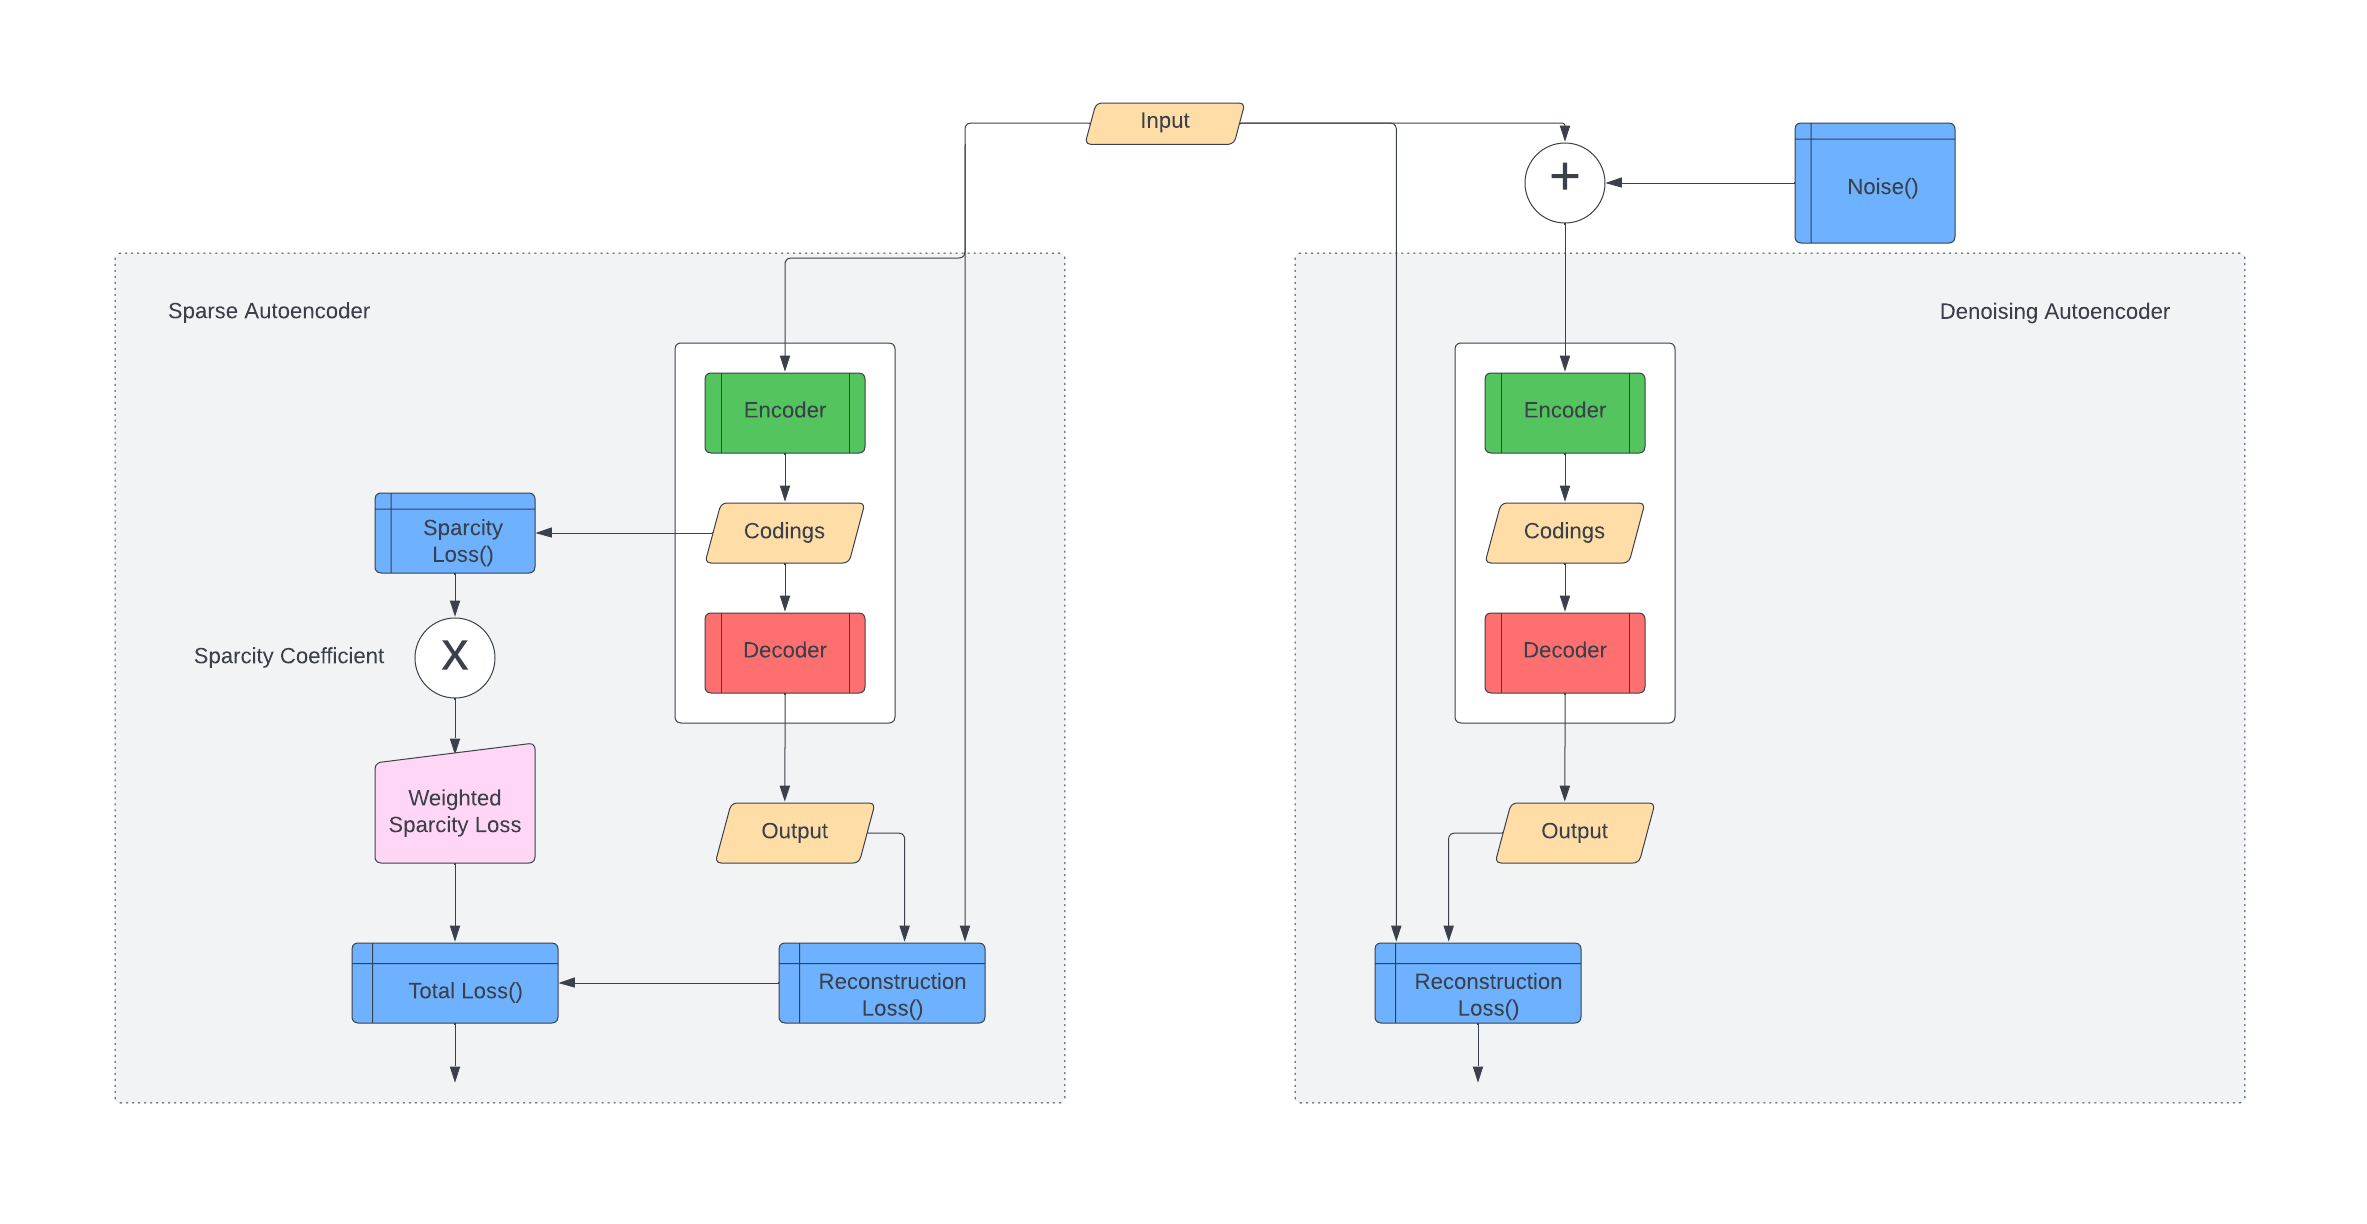

#### Sparse autoenoding

Although we bottleneck the representation in normal autoencoding by reducing the dimensionality, sparse autoencoders can actually increase it, but restrict it to be sparsely activated with L1 regularization using [tf.norm](https://www.tensorflow.org/api_docs/python/tf/norm) or KL-divergence. This has the effect of only having non-zero values in a few dimensions, effectively bottlenecking each representation, but giving a greater variety of dimensions to choose to be used.

In [35]:
m = tf.random.normal((4,3))
print(m)
m_norm = tf.norm(m, ord=1, axis=1) # sum of absolute row values
print(m_norm)

tf.Tensor(
[[-1.9031774  -0.9967917  -2.0883553 ]
 [-0.9290022  -0.71832746 -1.5451522 ]
 [-0.4294184   0.6812408   0.12057168]
 [-1.5585344   0.70575124  0.4639838 ]], shape=(4, 3), dtype=float32)
tf.Tensor([4.988324  3.192482  1.231231  2.7282693], shape=(4,), dtype=float32)


In [16]:
def sparse_autoencoder_loss(x, code, x_hat, sparsity_coeff=5.):
    sparsity_loss = tf.norm(code, ord=1, axis=1) # adding input coding values along each row
    reconstruction_loss = tf.reduce_mean(tf.square(x_hat - x)) # Mean Square Error
    total_loss = reconstruction_loss + sparsity_coeff * sparsity_loss
    return total_loss

max_steps = 250
step = 0
optimizer = tf.keras.optimizers.Adam()
for batch in tqdm(train_ds):
    with tf.GradientTape() as tape:
        x = tf.cast(batch['image'], tf.float32)
        code = encoder_network(x)
        output = decoder_network(code)
        loss = sparse_autoencoder_loss(x, code, output)
    gradient = tape.gradient(loss, encoder_network.trainable_variables + decoder_network.trainable_variables)
    optimizer.apply_gradients(zip(gradient, encoder_network.trainable_variables + decoder_network.trainable_variables))
    step += 1
    if step > max_steps:
        break

 13%|█▎        | 250/1875 [05:21<34:52,  1.29s/it]


In [ ]:
# Show a code (which should be pretty sparse)
# print(code[0])

Original and Reconstruction


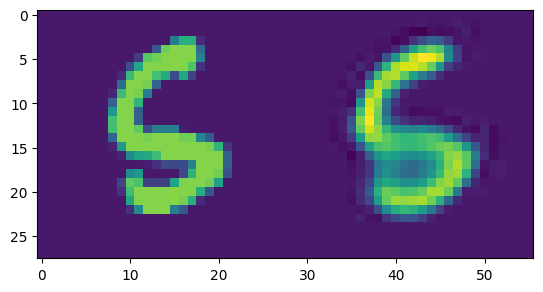

In [18]:
# Show reconstruction
# This will perform much better with more training and hyperparameter tuning
print("Original and Reconstruction")
side_by_side = tf.concat([x[0], output[0]], 1).numpy()
plt.imshow(side_by_side)

#### Denoising Autoencoder

Another way to force an autoencoder to learn the features of data is to force it to map noisy, corrupted versions of the data back to the original. This is usually accomplished by manually adding noice (e.g., Gaussian), but may also be useful in real world settings.

In [19]:
NOISE_COEFF = 10.

def autoencoder_loss(x, x_hat):
    reconstruction_loss = tf.reduce_mean(tf.square(x_hat - x)) # Mean Square Error
    total_loss = reconstruction_loss
    return total_loss

max_steps = 250
step = 0
optimizer = tf.keras.optimizers.Adam()
for batch in tqdm(train_ds):
    with tf.GradientTape() as tape:
        x = tf.cast(batch['image'], tf.float32)
        code = encoder_network(x + tf.random.normal(x.shape)) # you can multiphy the noise by NOISE_COEFF
        output = decoder_network(code)
        loss = autoencoder_loss(x, output)
    gradient = tape.gradient(loss, encoder_network.trainable_variables + decoder_network.trainable_variables)
    optimizer.apply_gradients(zip(gradient, encoder_network.trainable_variables + decoder_network.trainable_variables))
    step += 1
    if step > max_steps:
        break

 13%|█▎        | 250/1875 [04:24<28:42,  1.06s/it]


In [ ]:
# Show a code (which should be pretty sparse)
# print(code[0])

Original and Reconstruction


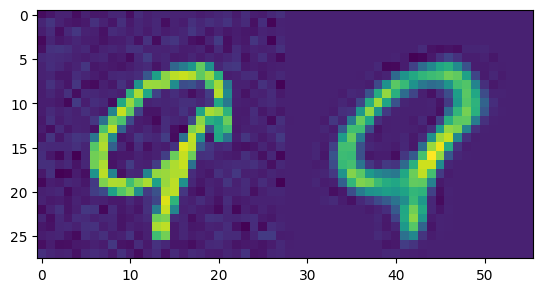

In [21]:
# Show reconstruction
# This will perform much better with more training and hyperparameter tuning
print("Original and Reconstruction")
side_by_side = tf.concat([x[0] + NOISE_COEFF * tf.random.normal(x[0].shape), output[0]], 1).numpy()
plt.imshow(side_by_side)

### Homework

Try out the autoencoder architecture above and test out the relationship between the mean squared error and the size of the latent variable (e.g., the (7,7,1) shape used above) using the above architecture on MNIST after some training. Try 2 or 3 code sizes (or more if you like) and report the parameters of a best fit line.

Reduce the code size (shape=7,7,1) to a single value (7x7x1 = 49) to allow you to represent it on an axis.

Equation of a line is Ax+By+C=0. in your homework (a PDF or TXT file), provide the values of A, B, and C

### Coda

#### [Progressive GAN latent space interpolation on Youtube](https://youtu.be/XOxxPcy5Gr4?t=1m48s)